# 预训练思路

预训练网络：使用已经在大型数据集（大规模图像分类任务：如ImageNet）上训练好的网络。

优势：能很好应对大规模数据集的网络，其“**提取特征的能力**”非常强！用它来处理小任务时，很轻松的就能提取有效特征。

所需做的调整：
- 卷积特征提取部分不论是网络架构还是权重参数，都直接完全使用预训练的网络。
- 后面Dense全连接层，根据自己的需要做调整即可（加自己的分类器）。

原因：因为：卷积层专门负责“**特征提取**”，全连接层专门负责“**特征汇聚**”。卷积层的特征提取能力与输入什么数据无关，在一定的“**网络架构 + 已训练好的参数**”条件下，不管什么图都能很好的提取特征 —— 因为我们完全可以利用别人做好的卷积机基部分，全连接层部分我们自己加。

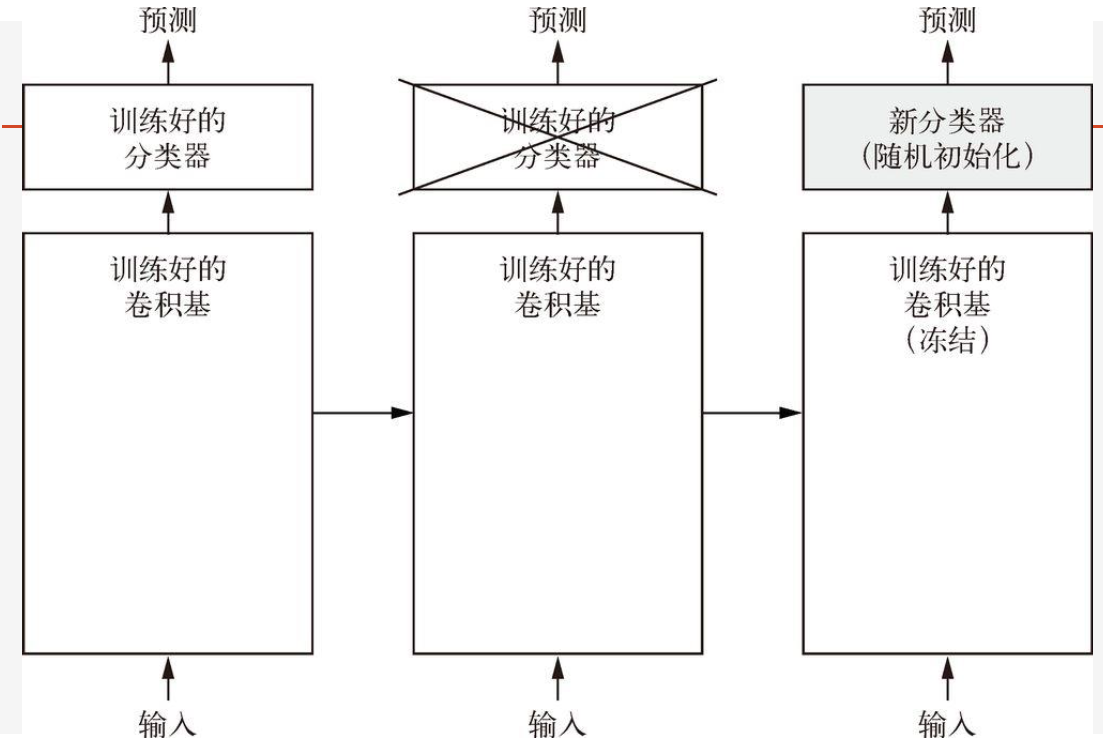

# 使用预训练的VGG16：处理猫狗数据集

### 数据预处理 

In [2]:
import keras
from keras import layers
import numpy as np
import os
import shutil    # os和shutil用来处理文件

Using TensorFlow backend.


In [3]:
# 原始数据太多了，现在专门创建一个文件夹来存储一部分要用的训练集 + 测试集
base_dir = 'E:/Python_code/keras_total/日月光华-keras课程资料/dc/try'
train_dir = os.path.join(base_dir, 'train')
train_dir_dog = os.path.join(train_dir , 'dog')
train_dir_cat = os.path.join(train_dir , 'cat')

test_dir = os.path.join(base_dir , 'test')
test_dir_dog = os.path.join(test_dir , 'dog')
test_dir_cat = os.path.join(test_dir , 'cat')

dc_dir = 'E:/Python_code/keras_total/日月光华-keras课程资料/dc/train' # 原始数据所在路径

In [4]:
# 训练集猫狗各1000张，测试集猫狗各500张。
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(train_dir_dog)
    os.mkdir(train_dir_cat)
    os.mkdir(test_dir)
    os.mkdir(test_dir_dog)
    os.mkdir(test_dir_cat)

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname) 
        d = os.path.join(train_dir_cat, fname)
        shutil.copyfile(s, d)   #  把s拷贝到d 

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(test_dir_cat, fname)
        shutil.copyfile(s, d)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(train_dir_dog, fname)
        shutil.copyfile(s, d)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(test_dir_dog, fname)
        shutil.copyfile(s, d)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
# 创建图片的迭代器，并且设定它的归一化
train_datagen = ImageDataGenerator(1/255)
test_datagen = ImageDataGenerator(1/255)

In [15]:
# 正式创建图片的生成器：train
train_generator = train_datagen.flow_from_directory( train_dir,                  # 待读取文件的目录
                                                     target_size = (200,200),    # 图片的统一大小 
                                                     batch_size = 20,            # 每次读入20张
                                                     class_mode = 'binary'       # 该文件夹下分两类：因为我已经正好在该文件夹下分了两个文件夹
)

# 正式创建图片的生成器：test
test_generator = test_datagen.flow_from_directory( test_dir,                  # 待读取文件的目录
                                                    target_size = (200,200),    # 图片的统一大小 
                                                    batch_size = 20,            # 每次读入20张
                                                    class_mode = 'binary'       # 该文件夹下分两类：因为我已经正好在该文件夹下分了两个文件夹
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 使用keras内置VGG16网络：

In [16]:
# 导入keras内置的VGG16网络：
# weights参数：使用训练imagenet后得到的权重参数；若不设置该参数，则默认只使用VGG16的“层结构”
# include_top参数：是否引入VGG16自带的分类器
conv_base = keras.applications.VGG16( weights = 'imagenet', include_top = False)

In [17]:
# 展示卷积基：
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### 创建模型 + 卷积基加入 

In [18]:
from keras import layers

# 添加全连接层：
model = keras.Sequential()
model.add( conv_base )  # 把卷积基先加入：一个网络可以直接当作另外一个模型中的某些层，非常方便！
model.add( layers.GlobalAveragePooling2D() )  # 与layers.Flatten()功能一样，它的效率更高（这两年才出的）
model.add( layers.Dense(512, activation='relu') )
model.add( layers.Dense(1, activation='relu') )

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


In [20]:
conv_base.trainable = False   # 卷积基不可训练：也就是这些层的权重在反向传播过程中不能改！ —— 很好理解

In [21]:
model.summary()  # 可训练参数一下子少了！

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
model.compile( optimizer='adam',
               loss = 'binary_crossentropy',
               metrics=['acc']
)

In [ ]:
# 此时输入数据是“generator生成器”，所以用model.fit_generator
history = model.fit_generator( 
     # 训练数据：
     train_generator,
     epochs = 2,
     steps_per_epoch = 100,  # 有2000张图，每次录入20张，因此100步可以走完一个epoch！不设置的话，生成器会一直循环生成
     # 测试数据：
     validation_data = test_generator, 
     validation_steps = 50   # 有1000张图，每次录入20张，故50步即可走完一个epoch！
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/2


e:\pycharm\python374\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 33/100 [========>.....................] - ETA: 2:01 - loss: 7.7631 - acc: 0.0152